# Homework 2
## Extracting TopUniversities and TimesHigherEducation Data

## Library

In [86]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import seaborn
%matplotlib inline

## Vars

In [2]:
web_urls = [{'page':'https://www.topuniversities.com',
             'data':'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt'},
            {'page':'https://www.timeshighereducation.com/world-university-rankings/2018/world-ranking#!/page/0/length/25/sort_by/rank/sort_order/asc/cols/stats',
             'data':'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'}]

#reading from pickle, avoid generating to many redundant traffic
#tu_top200 = pd.read_pickle("tu_top200_pickle")
#the_top200 = pd.read_pickle("the_top200_pickle")


## Functions

In [121]:
def get_number_elements(htmlPage, className):
    try:
        number = int(((htmlPage.find('div', class_=className)).find('div', class_="number").text).replace(',',''))    
    except AttributeError:
        number = 0
    return number

def crawl_topuniversities(url,n_top):
    http_response = requests.get(url['data'])
    universities = http_response.json()['data'][:n_top]
    list_universities = []
    for idx,university in enumerate(universities):
        
        university_region = university['region']
        university_country = university['location']
        university_rank = university['overall_rank']
        
        university_info_html = BeautifulSoup(university['uni'], 'html.parser')
        link_element = university_info_html.find('a')
        
        university_name = link_element.text
        university_link = link_element.get('href')

        university_detail = requests.get(url['page']+university_link)
        university_detail_html = BeautifulSoup(university_detail.text, 'html.parser')
        
        n_f_members = get_number_elements(university_detail_html,"total faculty")    
        n_inter_f_members = get_number_elements(university_detail_html,"inter faculty") 
        
        n_students = get_number_elements(university_detail_html,"total student") 
        n_inter_students = get_number_elements(university_detail_html,"total inter") 
        
        university_data = ({
                                'rank': university_rank,
                                'university_name': university_name,
                                'country': university_country,
                                'region': university_region,
                                'total_faculty_members': n_f_members,
                                'total_international_faculty_members': n_inter_f_members,
                                'total_students': n_students,
                                'total_international_students': n_inter_students
                          })
        list_universities.append(university_data)
    
    universities = pd.DataFrame.from_dict(list_universities)
    
    return universities

def crawl_timeshighereducation(url,n_top):
    http_response = requests.get(url['data'])
    universities = http_response.json()['data'][:n_top]
    list_universities = []
    for university in universities:
        
        university_rank = university['rank']
        university_name = university['name']
        university_country = university['location']
        n_students = int(university['stats_number_students'].replace(',',''))
        student_staff_ratio = float(university['stats_student_staff_ratio'])
        inter_student_percentage = float(university['stats_pc_intl_students'].strip('%'))/100 
        
        university_data = ({
                                'rank': university_rank,
                                'university_name': university_name,
                                'country': university_country,
                                'student_staff_ratio': student_staff_ratio,
                                'percentage_international_students': inter_student_percentage,
                                'total_students': n_students
                          })
        list_universities.append(university_data)
        
    universities = pd.DataFrame.from_dict(list_universities)
    return universities   

## Main Homework

### 1.Analysis of Top Universities Data

In [56]:
tu_top200 = crawl_topuniversities(web_urls[0],200)

In [57]:
tu_top200.head()

,country,rank,region,total_faculty_members,total_international_faculty_members,total_international_students,total_students,university_name
0,United States,1,North America,2982,1679,3717,11067,Massachusetts Institute of Technology (MIT)
1,United States,2,North America,4285,2042,3611,15878,Stanford University
2,United States,3,North America,4350,1311,5266,22429,Harvard University
3,United States,4,North America,953,350,647,2255,California Institute of Technology (Caltech)
4,United Kingdom,5,Europe,5490,2278,6699,18770,University of Cambridge


#### 1a. Best Universities: Ratio Faculty Members / Students

In [97]:
f_members_students_r = pd.DataFrame(tu_top200.university_name)
f_members_students_r["faculty_member_student_ratio"] = (tu_top200.total_faculty_members/tu_top200.total_students)
f_members_students_r.sort_values("faculty_member_student_ratio",ascending=False).head(3)

,university_name,faculty_member_student_ratio
3,California Institute of Technology (Caltech),0.422616
15,Yale University,0.398323
5,University of Oxford,0.342292


#### 1b. Best Universities: International Student Ratio

In [98]:
inter_students_r = pd.DataFrame(tu_top200.university_name)
inter_students_r["international_student_ratio"] = (tu_top200.total_international_students/tu_top200.total_students)
inter_students_r.sort_values("international_student_ratio",ascending=False).head(3)

,university_name,international_student_ratio
34,London School of Economics and Political Scien...,0.691393
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047
7,Imperial College London,0.543567


#### 1c. Best Universities: (1a) & (1b) by Country

In [99]:
df_c = f_members_students_r
df_c['country'] = tu_top200['country']
df_c['international_student_ratio'] = inter_students_r['international_student_ratio']

display(df_c.sort_values('faculty_member_student_ratio', ascending=False).groupby('country', as_index=False).first())
display(df_c.sort_values('international_student_ratio', ascending=False).groupby('country', as_index=False).first())

,country,university_name,faculty_member_student_ratio,international_student_ratio
0,Argentina,Universidad de Buenos Aires (UBA),0.134267,0.221658
1,Australia,The Australian National University,0.110788,0.384365
2,Austria,University of Vienna,0.074205,0.314748
3,Belgium,Vrije Universiteit Brussel (VUB),0.193020,0.199591
4,Brazil,Universidade de São Paulo,0.084948,0.031745
5,Canada,McMaster University,0.136318,0.149692
6,Chile,Pontificia Universidad Católica de Chile (UC),0.083694,0.036700
7,China,Tsinghua University,0.151680,0.112176
8,Denmark,Technical University of Denmark,0.238455,0.236314
9,Finland,University of Helsinki,0.117980,0.055043


,country,university_name,faculty_member_student_ratio,international_student_ratio
0,Argentina,Universidad de Buenos Aires (UBA),0.134267,0.221658
1,Australia,The University of Melbourne,0.078493,0.427434
2,Austria,University of Vienna,0.074205,0.314748
3,Belgium,Vrije Universiteit Brussel (VUB),0.193020,0.199591
4,Brazil,Universidade Estadual de Campinas (Unicamp),0.074063,0.036354
5,Canada,McGill University,0.126435,0.330825
6,Chile,Pontificia Universidad Católica de Chile (UC),0.083694,0.036700
7,China,Peking University,0.123054,0.168265
8,Denmark,Technical University of Denmark,0.238455,0.236314
9,Finland,Aalto University,0.103482,0.150737


#### 1d. Best Universities: (1a) & (1b) by Region

In [100]:
df_d = f_members_students_r
df_d['region'] = tu_top200['region']
df_d['international_student_ratio'] = inter_students_r['international_student_ratio']

display(df_d.sort_values('faculty_member_student_ratio', ascending=False).groupby('region', as_index=False).first())
display(df_d.sort_values('international_student_ratio', ascending=False).groupby('region', as_index=False).first())

,region,university_name,faculty_member_student_ratio,country,international_student_ratio
0,Africa,University of Cape Town,0.088450,South Africa,0.169703
1,Asia,Pohang University of Science And Technology (P...,0.213025,South Korea,0.040423
2,Europe,University of Oxford,0.342292,United Kingdom,0.372870
3,Latin America,Instituto Tecnológico y de Estudios Superiores...,0.136214,Mexico,0.105562
4,North America,California Institute of Technology (Caltech),0.422616,United States,0.286918
5,Oceania,The Australian National University,0.110788,Australia,0.384365


,region,university_name,faculty_member_student_ratio,country,international_student_ratio
0,Africa,University of Cape Town,0.088450,South Africa,0.169703
1,Asia,The University of Hong Kong,0.149006,Hong Kong,0.407144
2,Europe,London School of Economics and Political Scien...,0.111475,United Kingdom,0.691393
3,Latin America,Universidad de Buenos Aires (UBA),0.134267,Argentina,0.221658
4,North America,Carnegie Mellon University,0.100479,United States,0.478062
5,Oceania,The University of Melbourne,0.078493,Australia,0.427434


#### Plot

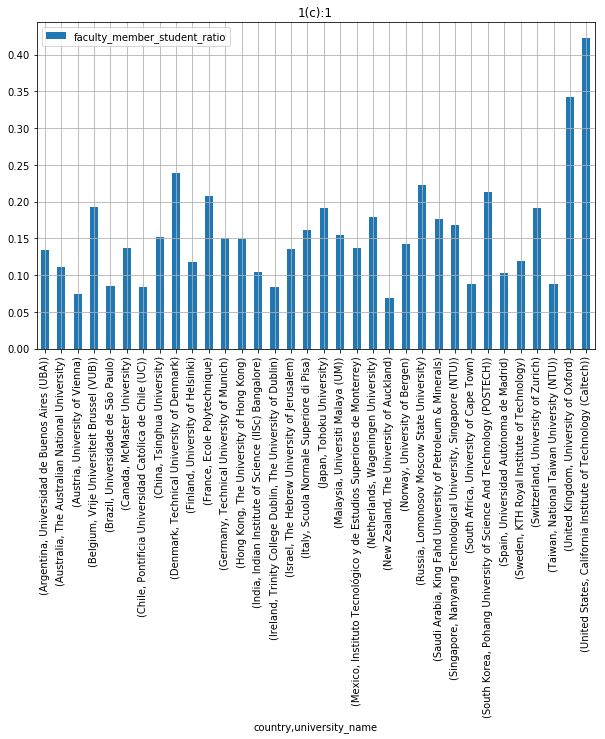

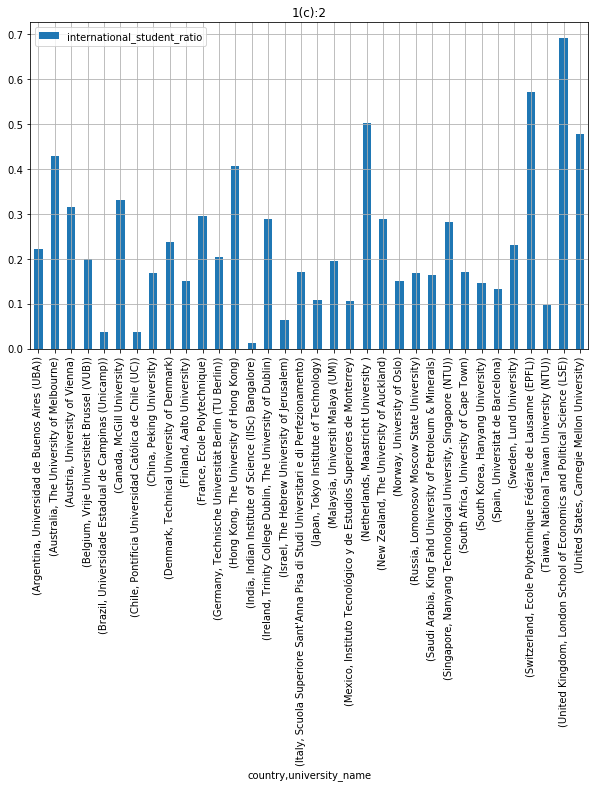

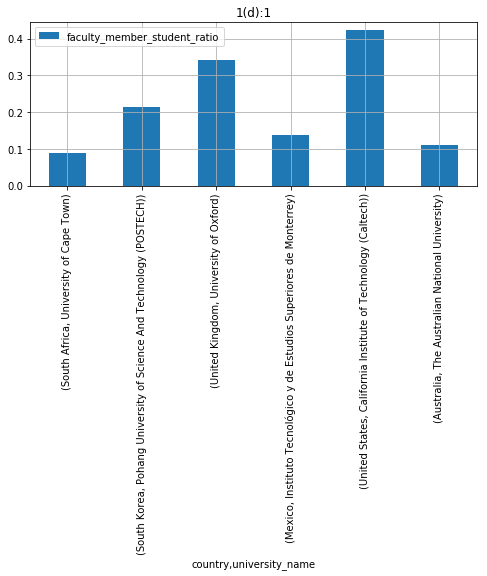

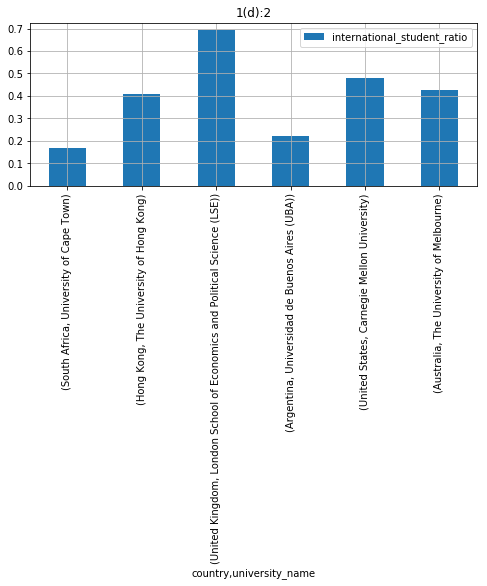

In [107]:
plot01_data = df_c.sort_values('faculty_member_student_ratio', ascending=False).groupby('country', as_index=False).first()
plot02_data = df_c.sort_values('international_student_ratio', ascending=False).groupby('country', as_index=False).first()

plot03_data = df_d.sort_values('faculty_member_student_ratio', ascending=False).groupby('region', as_index=False).first()
plot04_data = df_d.sort_values('international_student_ratio', ascending=False).groupby('region', as_index=False).first()

plot01=plot01_data.plot(y='faculty_member_student_ratio', x=['country','university_name'], kind='bar', grid=True, figsize=(10, 6), title='1(c):1')
plot02=plot02_data.plot(y='international_student_ratio', x=['country','university_name'], kind='bar', grid=True, figsize=(10, 6), title='1(c):2')
plot03=plot03_data.plot(y='faculty_member_student_ratio', x=['country','university_name'], kind='bar', grid=True, figsize=(8, 3), title='1(d):1')
plot04=plot04_data.plot(y='international_student_ratio', x=['country','university_name'], kind='bar', grid=True, figsize=(8, 3), title='1(d):2')


* Writing Data into a file

In [ ]:
tu_top200.to_pickle("tu_top200_pickle")

### 2.Analysis of Times Higher Education Data

In [122]:
the_top200 = crawl_timeshighereducation(web_urls[1],200)

In [123]:
the_top200.head()

,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
0,United Kingdom,0.38,1,11.2,20409,University of Oxford
1,United Kingdom,0.35,2,10.9,18389,University of Cambridge
2,United States,0.27,=3,6.5,2209,California Institute of Technology
3,United States,0.22,=3,7.5,15845,Stanford University
4,United States,0.34,5,8.7,11177,Massachusetts Institute of Technology


#### 2a. Best Universities: Student/Staff Ratio

In [124]:
the_top200.sort_values("student_staff_ratio",ascending=False).head(3)

,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
99,Germany,0.13,=100,77.9,35619,University of Bonn
124,Germany,0.16,125,74.5,10995,University of Mannheim
91,Germany,0.20,92,64.3,22390,Technical University of Berlin


#### 2b. Best Universities: International Student Ratio

In [125]:
the_top200.sort_values("percentage_international_students",ascending=False).head(3)

,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
24,United Kingdom,0.71,=25,12.2,10065,London School of Economics and Political Science
178,Luxembourg,0.57,=179,14.6,4969,University of Luxembourg
37,Switzerland,0.55,=38,11.2,9928,École Polytechnique Fédérale de Lausanne


#### 2c. Best Universities: (2a) & (2b) by Country

In [126]:
display(the_top200.sort_values('student_staff_ratio', ascending=False).groupby('country', as_index=False).first())
display(the_top200.sort_values('percentage_international_students', ascending=False).groupby('country', as_index=False).first())


,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
0,Australia,0.26,65,35.7,38968,University of Queensland
1,Austria,0.26,=165,20.8,35375,University of Vienna
2,Belgium,0.35,=175,43.4,25343,Université Libre de Bruxelles
3,Canada,0.15,78,24.7,23693,McMaster University
4,China,0.10,=169,14.2,33456,Nanjing University
5,Denmark,0.12,=109,14.3,25167,Aarhus University
6,Finland,0.20,190,20.2,12744,Aalto University
7,France,0.15,196,30.2,22042,Paris-Sorbonne University – Paris 4
8,Germany,0.13,=100,77.9,35619,University of Bonn
9,Hong Kong,0.25,=182,26.9,21773,Hong Kong Polytechnic University


,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
0,Australia,0.40,32,26.6,42116,University of Melbourne
1,Austria,0.26,=165,20.8,35375,University of Vienna
2,Belgium,0.35,=175,43.4,25343,Université Libre de Bruxelles
3,Canada,0.29,=34,18.1,51889,University of British Columbia
4,China,0.16,=27,8.9,42136,Peking University
5,Denmark,0.24,=153,6.0,8548,Technical University of Denmark
6,Finland,0.20,190,20.2,12744,Aalto University
7,France,0.36,115,5.1,2799,École Polytechnique
8,Germany,0.23,41,54.4,38689,Technical University of Munich
9,Hong Kong,0.42,40,18.0,18364,University of Hong Kong


* Writing Data into a file

In [9]:
the_top200.to_pickle("the_top200_pickle")